In [1]:
# stdlib
import os
import glob
import re
import struct
from concurrent.futures import ThreadPoolExecutor, as_completed

# data & imaging
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from skimage.metrics import structural_similarity as ssim


# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader

# torchvision
import torchvision
from torchvision import transforms

# metrics & plotting
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Colab
from google.colab import drive

In [2]:
import torch.nn.functional as F
from torchvision.ops import sigmoid_focal_loss

In [3]:
# ─── 1) MOUNT GOOGLE DRIVE ──────────────────────────────────────────────
drive.mount('/content/drive', force_remount=True)

# ─── 2) DEVICE & CUDNN ──────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cudnn.benchmark = True  # auto‐tune for fixed input sizes

Mounted at /content/drive


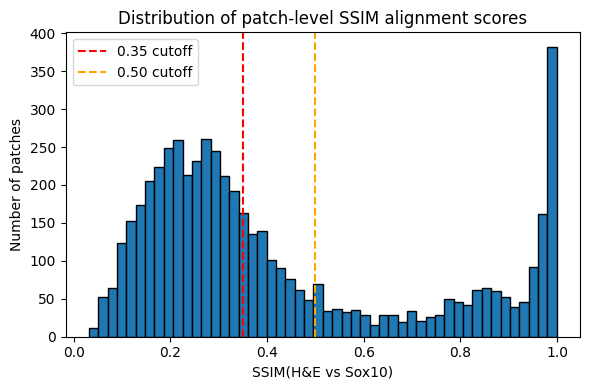

In [14]:
all_scores = []
for he_path, melan_path, sox10_path in all_triplets:
    # load & normalize to [0,1]
    he = Image.open(he_path).convert('L').resize((224,224))
    s10 = Image.open(sox10_path).convert('L').resize((224,224))
    arr_he  = np.array(he,  dtype=np.float32) / 255.0
    arr_s10 = np.array(s10, dtype=np.float32) / 255.0

    # must pass data_range=1.0 for float inputs
    score, _ = ssim(arr_he, arr_s10, data_range=1.0, full=True)
    all_scores.append(score)

# 2) Plot
plt.figure(figsize=(6,4))
plt.hist(all_scores, bins=50, edgecolor='black')
plt.xlabel("SSIM(H&E vs Sox10)")
plt.ylabel("Number of patches")
plt.title("Distribution of patch‐level SSIM alignment scores")
plt.axvline(0.35, color='red', linestyle='--', label='0.35 cutoff')
plt.axvline(0.50, color='orange', linestyle='--', label='0.50 cutoff')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
import os, re
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split

# ─── 1) CONFIG ──────────────────────────────────────────────────────────
image_folder = "/content/drive/MyDrive/patches_cross_new"
batch_size   = 64
num_workers  = 4
lr           = 1e-3
num_epochs   = 10
test_size    = 0.25
min_ssim     = 0.80
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─── 2) LABELS ───────────────────────────────────────────────────────────
labels_df = pd.read_csv("/content/drive/MyDrive/case_grade_match.csv")
class_map = {int(r.Case): (0 if r.Class == 1 else 1) for _, r in labels_df.iterrows()}

# ─── 3) BUILD ALL TRIPLETS ───────────────────────────────────────────────
def get_all_triplets(patch_dir):
    triplet_dict = {}
    matched = 0

    for fname in os.listdir(patch_dir):
        low = fname.lower()
        # Capture: case, match, patch index, stain
        m = re.match(
            r'case_(\d+)_match_(\d+)_h&e_patch(\d+)_?(h&e|melan|sox10)\.png',
            low
        )
        if not m:
            continue
        matched += 1

        cid, mid, pid, stain = int(m.group(1)), int(m.group(2)), int(m.group(3)), m.group(4)
        if cid not in class_map:
            continue

        key = (cid, mid, pid)
        triplet_dict.setdefault(key, {})[stain] = os.path.join(patch_dir, fname)

    print(f"🔍 Files matching pattern: {matched}")
    print(f"🔍 Unique (case,match,patch) keys: {len(triplet_dict)}")

    # Now only keep those keys where all 3 stains are present
    triplets, labels = [], []
    for (cid, mid, pid), stains in triplet_dict.items():
        if all(s in stains for s in ('h&e','melan','sox10')):
            triplets.append([stains['h&e'], stains['melan'], stains['sox10']])
            labels.append(class_map[cid])

    print(f"✅ Complete triplets formed: {len(triplets)}")
    return triplets, labels

all_triplets, all_labels = get_all_triplets(image_folder)

# ─── 3b) FILTER BY PATCH-SIZE P20–P80 ────────────────────────────────────
# (we’ll use the H&E patch [0] as representative)
areas = []
for triplet in all_triplets:
    he_path = triplet[0]
    w, h = Image.open(he_path).size
    areas.append(w * h)

# compute the 20th and 80th percentiles
p20, p80 = np.percentile(areas, [20, 80])
print(f"20th pct patch-area = {p20:.0f}px, 80th pct = {p80:.0f}px")

# now filter
filtered_trips  = []
filtered_labels = []
for trip, lbl, area in zip(all_triplets, all_labels, areas):
    if p20 <= area <= p80:
        filtered_trips .append(trip)
        filtered_labels.append(lbl)

print(f"Kept {len(filtered_trips)}/{len(all_triplets)} triplets after size filter")

# ─── 4) STRATIFIED SPLIT ─────────────────────────────────────────────────
train_trips, test_trips, train_lbls, test_lbls = train_test_split(
    all_triplets, all_labels, test_size=test_size, stratify=all_labels, random_state=42
)

# ─── 5) TRANSFORMS ───────────────────────────────────────────────────────
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

# ─── 6) DATASET ──────────────────────────────────────────────────────────
class TripletAveragingDataset(Dataset):
    def __init__(self, triplets, labels, transform=None,
                 min_ssim=0.80, resize=(224, 224)):
        """
        triplets:   list of [he_path, melan_path, sox10_path]
        labels:     list of integer labels (0 or 1) of the same length
        transform:  torchvision transforms to apply AFTER averaging
        min_ssim:   SSIM threshold below which we treat Sox10 as 'misaligned'
        resize:     (width, height) to resize each patch BEFORE computing SSIM or averaging
        """
        assert len(triplets) == len(labels)
        self.samples   = list(zip(triplets, labels))
        self.transform = transform
        self.min_ssim  = min_ssim
        self.resize    = resize

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns: (averaged_image_tensor, label)
        - If H&E vs Sox10 SSIM < min_ssim, average only H&E+Melan
        - Else average H&E+Melan+Sox10
        """
        (he_path, melan_path, sox10_path), label = self.samples[idx]

        # 1) Load & resize all three patches as PIL
        he_img    = Image.open(he_path).convert('RGB').resize(self.resize)
        melan_img = Image.open(melan_path).convert('RGB').resize(self.resize)
        sox10_img = Image.open(sox10_path).convert('RGB').resize(self.resize)

        # 2) Compute SSIM on grayscale H&E vs Sox10
        he_gray    = np.array(he_img.convert('L'), dtype=np.float32) / 255.0
        sox10_gray = np.array(sox10_img.convert('L'), dtype=np.float32) / 255.0

        # NOTE: specify data_range=1.0 because arrays are float32 in [0,1]
        score, _   = ssim(he_gray, sox10_gray, data_range=1.0, full=True)

        # 3) Decide which patches to average
        if score < self.min_ssim:
            # treat Sox10 as misaligned → only average H&E + Melan
            imgs_to_avg = [he_img, melan_img]
        else:
            # all three aligned → average H&E + Melan + Sox10
            imgs_to_avg = [he_img, melan_img, sox10_img]

        # 4) Convert chosen PILs to NumPy, average, then back to PIL
        arrs = [np.array(im, dtype=np.float32) for im in imgs_to_avg]
        avg_arr = np.mean(arrs, axis=0).astype(np.uint8)
        avg_img = Image.fromarray(avg_arr)

        # 5) Apply any torchvision transforms (e.g. Resize→ToTensor→Normalize)
        if self.transform:
            avg_img = self.transform(avg_img)

        return avg_img, label

    def is_mostly_blank(self, img):
        img_np = np.array(img)
        white_mask = (img_np > 240).all(axis=-1)
        return white_mask.sum() / white_mask.size > 0.9

    def average_images(self, imgs):
        imgs_np = [np.array(im, dtype=np.float32) for im in imgs]
        avg = np.mean(imgs_np, axis=0).astype(np.uint8)
        return Image.fromarray(avg)

# ─── 7) DATA LOADERS ─────────────────────────────────────────────────────
train_ds = TripletAveragingDataset(train_trips, train_lbls, transform=transform)
test_ds  = TripletAveragingDataset(test_trips,  test_lbls,  transform=transform)

train_labels_final = [lbl for _, lbl in train_ds]
class_counts = np.bincount(train_labels_final)
class_weights = [1.0 / c for c in class_counts]
sample_weights = [class_weights[lbl] for lbl in train_labels_final]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler,
                          num_workers=num_workers, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True, persistent_workers=True)

# ─── 8) MODEL ────────────────────────────────────────────────────────────
model = torchvision.models.alexnet(pretrained=True)
for param in model.parameters(): param.requires_grad = False
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
model = model.to(device)

optimizer = optim.Adam(model.classifier[6].parameters(), lr=lr)
scaler = torch.cuda.amp.GradScaler()
focal_alpha = 0.70
focal_gamma = 2.0

optimizer = optim.Adam(model.classifier[6].parameters(), lr=lr)
scaler    = torch.cuda.amp.GradScaler()

# ─── 9) TRAIN LOOP with sigmoid_focal_loss ────────────────────────────────
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}', leave=False)
    for imgs, lbls in pbar:
        imgs, lbls = imgs.to(device), lbls.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(imgs)                        # shape [B, 2]
            # convert to one-hot float targets
            targets = F.one_hot(lbls, num_classes=2).float()  # shape [B, 2]
            loss = sigmoid_focal_loss(
                logits,
                targets,
                alpha=focal_alpha,
                gamma=focal_gamma,
                reduction='mean'
            )

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * lbls.size(0)
        pbar.set_postfix(loss=running_loss / ((pbar.n + 1) * batch_size))

    epoch_loss = running_loss / len(train_ds)
    print(f"Epoch {epoch}: Train Loss = {epoch_loss:.4f}")

# ─── 10) EVALUATION ──────────────────────────────────────────────────────
model.eval()
correct = total = 0
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds = model(imgs).argmax(1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)
print(f'Test Accuracy: {100 * correct / total:.2f}%')

🔍 Files matching pattern: 15666
🔍 Unique (case,match,patch) keys: 5222
✅ Complete triplets formed: 5222
20th pct patch-area = 1156px, 80th pct = 110224px
Kept 3149/5222 triplets after size filter


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNe

Epoch 1: Train Loss = 0.0599


Epoch 2: Train Loss = 0.0464


Epoch 3: Train Loss = 0.0443


Epoch 4: Train Loss = 0.0416


Epoch 5: Train Loss = 0.0417


Epoch 6: Train Loss = 0.0409


Epoch 7: Train Loss = 0.0414


Epoch 8: Train Loss = 0.0406


Epoch 9: Train Loss = 0.0408


Epoch 10: Train Loss = 0.0402


Test Accuracy: 84.99%


In [10]:
from collections import Counter

# pull all labels out of the dataset
train_labels = [lbl for _, lbl in train_ds]

# 12/22 cases are high-grade

# count how many 0’s vs 1’s
counts = Counter(train_labels)
print("Class counts:", counts)
print(f"Fraction class 0: {counts[0]/len(train_ds):.2%}")
print(f"Fraction class 1: {counts[1]/len(train_ds):.2%}")

Class counts: Counter({1: 2550, 0: 1366})
Fraction class 0: 34.88%
Fraction class 1: 65.12%


In [11]:
# ─── 9) PATCH‐LEVEL EVALUATION ───────────────────────────────────────────
model.eval()
all_preds, all_labels = [], []
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = (images.to(device, non_blocking=True),
                          labels.to(device, non_blocking=True))
        outputs = model(images)
        preds   = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

accuracy  = 100 * correct / total
precision = precision_score(all_labels, all_preds)
recall    = recall_score(all_labels, all_preds)
f1        = f1_score(all_labels, all_preds)

print(f"Test Patch‐level Accuracy : {accuracy:.2f}%")
print(f"Precision                : {precision:.4f}")
print(f"Recall                   : {recall:.4f}")
print(f"F1 Score                 : {f1:.4f}")

Test Patch‐level Accuracy : 84.99%
Precision                : 0.8999
Recall                   : 0.8660
F1 Score                 : 0.8826


In [12]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       455
           1       0.90      0.87      0.88       851

    accuracy                           0.85      1306
   macro avg       0.83      0.84      0.84      1306
weighted avg       0.85      0.85      0.85      1306



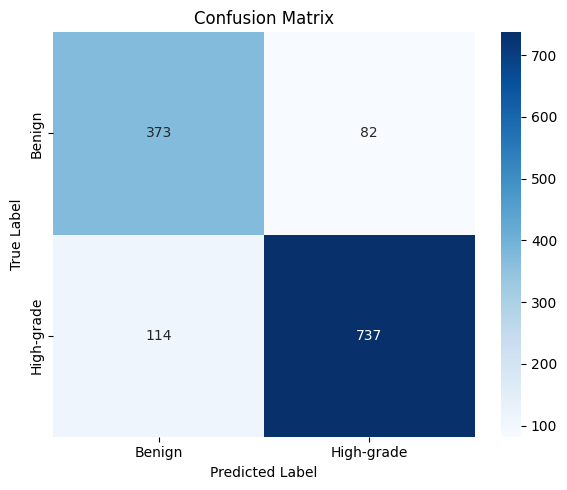

In [13]:
# ─── CONFUSION MATRIX ────────────────────────────────────────────────────
cm = confusion_matrix(all_labels, all_preds)
labels = ['Benign', 'High-grade']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()